I have been running simulations of the repository "k100Sim" on condor from the directory /home/phys/villaa/analysis/cdms_simulation/k100_ncapture_cal/condor some of these deal with varying the position of the sources and plotting the results.  This is what I consider here.  See N-MISC-17-003 pg 28. 

In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import h5py
import dataPython as dp
import scipy.interpolate as inter
import scipy.integrate as integrate
import scipy.optimize as optimize

/home/phys/villaa/python/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#a function to get three rows of data x y yerr
dataV = dp.getXYdata('data/Run66Sim_nearCryo_Vscan.txt')
dataR = dp.getXYdata('data/Run66Sim_nearCryo_Rscan.txt')

#turn into np array
dataV['xx'] = np.array(dataV['xx'])
dataV['yy'] = np.array(dataV['yy'])
dataR['xx'] = np.array(dataR['xx'])
dataR['yy'] = np.array(dataR['yy'])

#include sqrt(N) error
dataV['ey'] = np.sqrt(dataV['yy'])
dataR['ey'] = np.sqrt(dataR['yy'])

#convert the "radial" distance because the raw data lists the side of a 45deg right triangle
dataR['xx'] = np.sqrt([2])*dataR['xx']

#print(dataV)
#print(dataR)

#add in the factors for neutron flux V=258.5 cm^3; Sig=0.0955 cm^-1; nPrim=1e6; Source R=1.96e6 neut/s
V=258.50
Sig=0.0955
nPrim=1e6
SrcR=1.96e6

dataV['yy'] = dataV['yy']*(SrcR/nPrim)*(1/(V*Sig))
dataR['yy'] = dataR['yy']*(SrcR/nPrim)*(1/(V*Sig))
dataV['ey'] = dataV['ey']*(SrcR/nPrim)*(1/(V*Sig))
dataR['ey'] = dataR['ey']*(SrcR/nPrim)*(1/(V*Sig))

#make explicit vectors for the naught values
dataV0 = {}
dataR0 = {}
dataV0['xx'] = np.zeros(1)
dataV0['yy'] = np.ones(1)*5399
dataV0['ey'] = np.sqrt(dataV0['yy'])
nPrim=10e6
dataV0['yy'] = dataV0['yy']*(SrcR/nPrim)*(1/(V*Sig))
dataV0['ey'] = dataV0['ey']*(SrcR/nPrim)*(1/(V*Sig))

dataR0['xx'] = np.ones(1)*23.348
dataR0['xx'] = np.sqrt([2])*dataR0['xx']
dataR0['yy'] = np.ones(1)*5399
dataR0['ey'] = np.sqrt(dataR0['yy'])
nPrim=10e6
dataR0['yy'] = dataR0['yy']*(SrcR/nPrim)*(1/(V*Sig))
dataR0['ey'] = dataR0['ey']*(SrcR/nPrim)*(1/(V*Sig))

In [3]:
#trying to customize here, see:
#https://matplotlib.org/users/customizing.html
#matplotlib.rc('figure', figsize=(3.4, 3.4*(4/6)))
mpl.rcParams['lines.linewidth'] = 2

#ticks
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.bottom'] = True
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.major.size'] = 8
mpl.rcParams['xtick.minor.size'] = 4
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['xtick.labelsize'] = 22

mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.right'] = False
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.major.size'] = 8
mpl.rcParams['ytick.minor.size'] = 4
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['ytick.labelsize'] = 22

#error bars
#mpl.rcParams['errorbar.capsize'] = 3

#axis stuff
mpl.rcParams['axes.labelsize'] = 22

#fonts
# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'32'}
legend_font = {'fontname':'Arial', 'size':'22'}

#fonts global settings
mpl.rc('font',family=legend_font['fontname'])

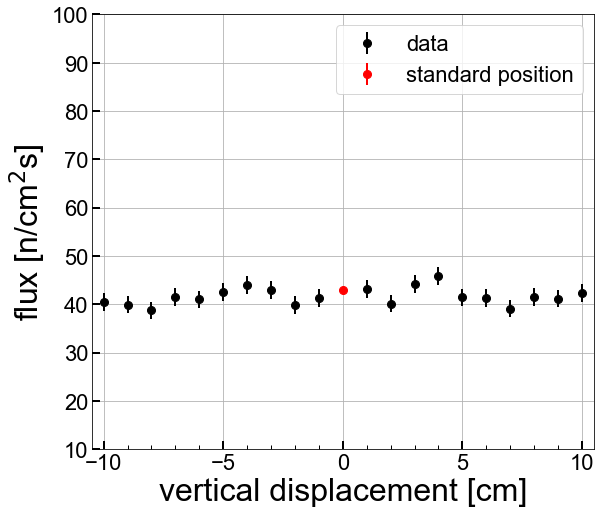

In [4]:
#set up a plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0))
ax1 = axes

#lay out the colors
rgb_r = (255/255.0,0/255.0,0/255.0)
rgb_b = (0/255.0,0/255.0,255/255.0)
rgb_o = (255/255.0,127/255.0,0/255.0)
rgb_b = (31/255.0,120/255.0,180/255.0)
rgb_lr = (251/255.0,154/255.0,153/255.0)
rgb_g = (203/255.0,195/255.0,195/255.0)

ax1.errorbar(dataV['xx'], dataV['yy'], yerr=dataV['ey'],marker='o', markersize=8, linestyle='none',color='k', label='data')
ax1.errorbar(dataV0['xx'], dataV0['yy'], yerr=dataV0['ey'],marker='o', markersize=8, linestyle='none',color='r', label='standard position')
#xx = np.arange(0,13,dx)


ax1.set_yscale('linear')
ax1.set_xlim(-10.5, 10.5)
ax1.set_ylim(10,100)
ax1.set_xlabel('vertical displacement [cm]',**axis_font)
ax1.set_ylabel('flux [n/cm$^2$s]',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
#ax1.legend([gh,gl,nh,nl], ['gamma (high gain)','gamma (low gain)','neutron (high gain)', 'neutron (low gain)'],loc=1)
#ax1.legend(loc=1, bbox_to_anchor=(0.82, 1),
#         fancybox=True, shadow=True, ncol=4)
ax1.legend(loc=1,prop={'size':22})

In [5]:
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

In [6]:
plt.tight_layout()
plt.savefig('figures/R66_Sim1_nearCryo_varyVert.eps')
plt.show()

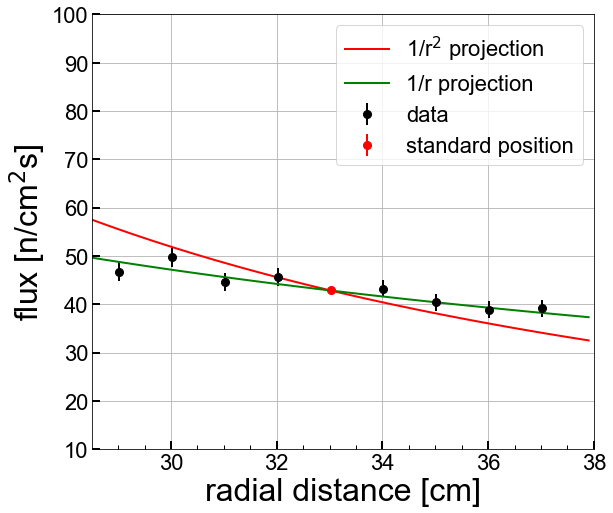

In [7]:
#set up a plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0))
ax1 = axes

#lay out the colors
rgb_r = (255/255.0,0/255.0,0/255.0)
rgb_b = (0/255.0,0/255.0,255/255.0)
rgb_o = (255/255.0,127/255.0,0/255.0)
rgb_b = (31/255.0,120/255.0,180/255.0)
rgb_lr = (251/255.0,154/255.0,153/255.0)
rgb_g = (203/255.0,195/255.0,195/255.0)

ax1.errorbar(dataR['xx'], dataR['yy'], yerr=dataR['ey'],marker='o', markersize=8, linestyle='none',color='k', label='data')
ax1.errorbar(dataR0['xx'], dataR0['yy'], yerr=dataR0['ey'],marker='o', markersize=8, linestyle='none',color='r', label='standard position')
#xx = np.arange(0,13,dx)

func = lambda x: dataR0['xx'][0]**2*dataR0['yy'][0]*(1/x**2)
funcr = lambda x: dataR0['xx'][0]*dataR0['yy'][0]*(1/x)
#print(func(dataR0['xx'][0]))
dx=0.1
xx = np.arange(28.5,38,dx)
ax1.plot (xx, func(xx), 'r-', label='1/r$^2$ projection')
ax1.plot (xx, funcr(xx), 'g-', label='1/r projection')


ax1.set_yscale('linear')
ax1.set_xlim(28.5, 38)
ax1.set_ylim(10,100)
ax1.set_xlabel('radial distance [cm]',**axis_font)
ax1.set_ylabel('flux [n/cm$^2$s]',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
#ax1.legend([gh,gl,nh,nl], ['gamma (high gain)','gamma (low gain)','neutron (high gain)', 'neutron (low gain)'],loc=1)
#ax1.legend(loc=1, bbox_to_anchor=(0.82, 1),
#         fancybox=True, shadow=True, ncol=4)
ax1.legend(loc=1,prop={'size':22})

In [8]:
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

In [9]:
plt.tight_layout()
plt.savefig('figures/R66_Sim1_nearCryo_varyRadial.eps')
plt.show()

It doesn't seem like any of these changes in flux with position are especially sharp for the high-flux situation.  It may mean that small changes in the position of the source will not make up the discrepancy (factor of 4 higher flux in simulation) for the high-flux configuration.  


Note that the low-flux configuration is too low in the simulation by a factor of 5 and the high-flux simulation is too high by a factor of 4. 

What, then, can be sources of systematics in the simulation?  Perhaps:

  * Parrafin composition/density
  * density of polyethylene
  * lack of 3He in the cryostat (can that sop up neutrons? and more so for the source closer?)
  * lack of walls and ceiling in simulation (wouldn't think this could decrease the high-flux sim)
  * improper capture physics (check the ratio of captures on each isotope)
  * improper neutron transport physics (check that the HP neutron library turned on)
  * density problems with other materials (check all materials for composition)
  * improper energy distribution of source (don't think so, check)
  * improper data analysis (currently simply counting all hits that had a neutron capture in the detector--seems fine)


Way forward: make a new version of the simulation with some simple changes/checks like:

  * fix depth of well
  * include concrete ceiling
  * check density of polyethylene we use
  